# German Bank Clients Clusterisation


## Import libraries

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=bc2c31068e4125b834fa61b3380c773dc8aa6ac205c6b0f4e30414a6785a57c2
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55640 sha256=857c6dc355f3426b1bfdf162a89094c6b1cd8e604dd1919344c760bb80f84824
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import umap
from functools import partial
from math import ceil
from sklearn.preprocessing import (OrdinalEncoder, 
                                   MinMaxScaler, 
                                   StandardScaler, 
                                   LabelEncoder)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from tqdm import tqdm

In [ ]:
def multiple_plots(dataset, columns, vizfunc, xyrot=(0, 0), gwidth=4, gheight=4, ncol=3, **kwargs):
    nrow = ceil(len(columns)/ncol)
    fig, axes = plt.subplots(nrow, ncol)
    fig.set_size_inches(ncol*gwidth, nrow*gheight)
    for ax, col in zip(axes.flatten(), columns):
        vizfunc(data=df, x=col, ax=ax, **kwargs)
        ax.tick_params('x', labelrotation=xyrot[0])
        ax.tick_params('y', labelrotation=xyrot[1])
    return fig, axes

## Read data

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (text - little, moderate, quite rich, rich)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [ ]:
df = pd.read_csv('german_credit_data.csv')
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,996,40,male,3,own,little,little,3857,30,car
997,997,38,male,2,own,little,NaN,804,12,radio/TV
998,998,23,male,2,free,little,little,1845,45,radio/TV


## EDA
Дропнем ненужную первую колонку:

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


## Categorical variables
Поле Job сконвертируем в текст для лучшей интерпретаци в ходе EDA.

In [ ]:
job_map = {
    0: 'unskilled and non-resident',
    1: 'unskilled and resident',
    2: 'skilled',
    3: 'highly skilled'
}
df['Job_cat'] = df['Job'].map(job_map)

Теперь можем визуализировать

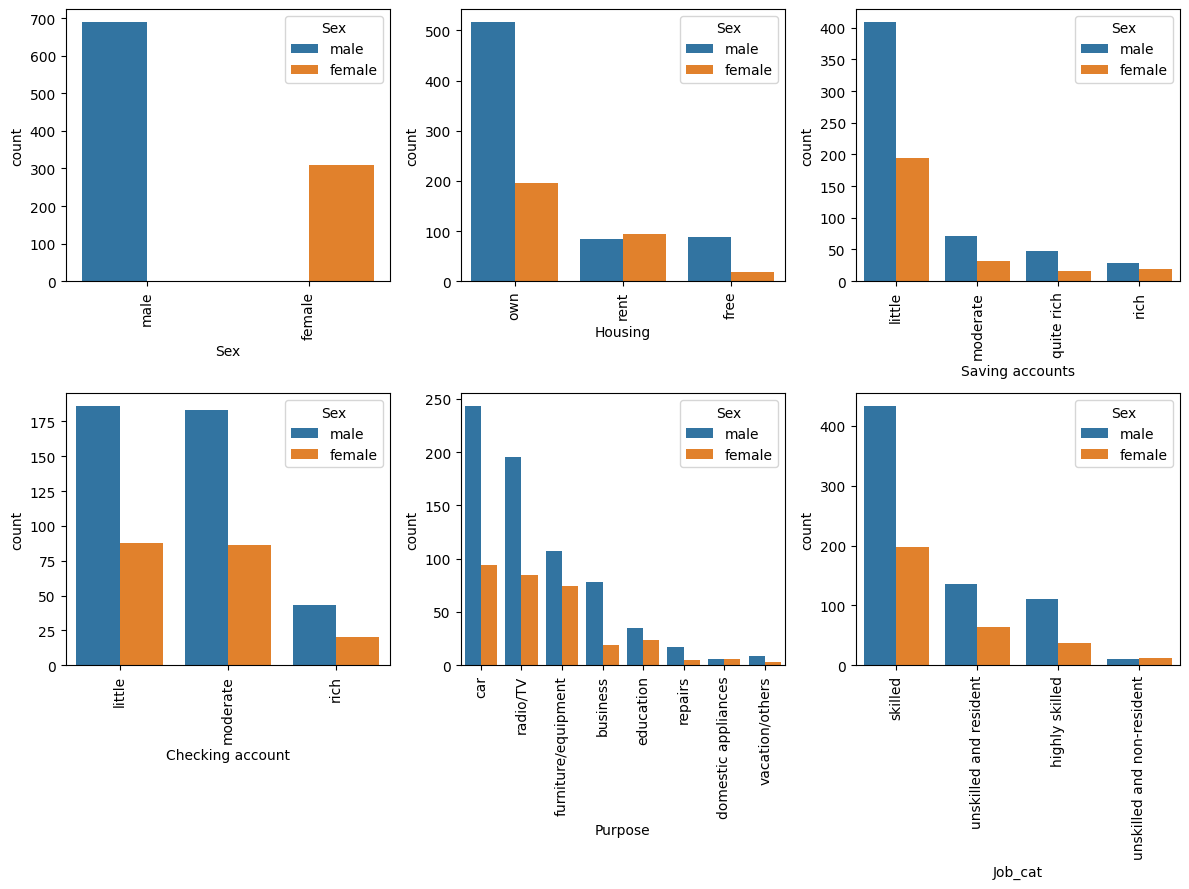

In [ ]:
cat_vars = df.select_dtypes('object').columns
ncol = 3
nrow = ceil(len(cat_vars)/ncol)
fig, axes = plt.subplots(nrow, ncol)
fig.set_size_inches(ncol*4, nrow*4.5)
for ax, cat in zip(axes.flatten(), cat_vars):
    sns.countplot(data=df, x=cat, ax=ax, hue='Sex', order=df[cat].value_counts().index)
    ax.tick_params('x', labelrotation=90)
plt.tight_layout()
plt.show()

- Мужчин в датасете в более чем в два раза больше чем женщин
- Почти во всех категориях соотношение между мужчинами и женщинами примерно одинаковое (как и во всем датасете). Самые заметные исключения:
	- Housing:rent - чуть больше женщин снимает жилье;
    - Housing:free - намного больше мужчин живет в беспланом жилом фонде;
    - Purpose: business, repairs, vacation/others - менее популярные цели кредитов среди женщин;
    - Purpose: domestic appliances - одинаково популярная категория;
    - Job_cat - чуть больше женщин-нерезидентов, занятых в работе не требующей особых навыков.

## Numeric variables
Посмотрим на распределение числовых признаков

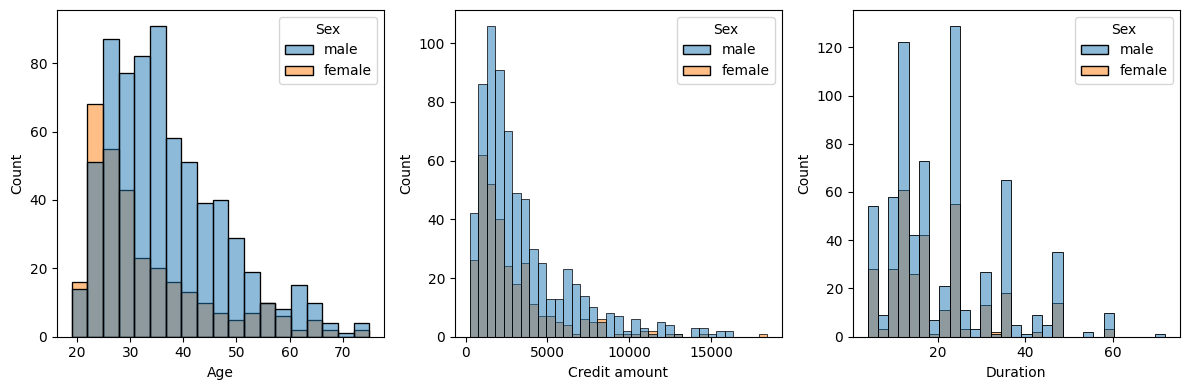

In [ ]:
num_vars = df.select_dtypes(exclude='object').drop('Job', axis=1).columns
multiple_plots(df, num_vars, sns.histplot, hue='Sex')
plt.tight_layout()
plt.show()

In [ ]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


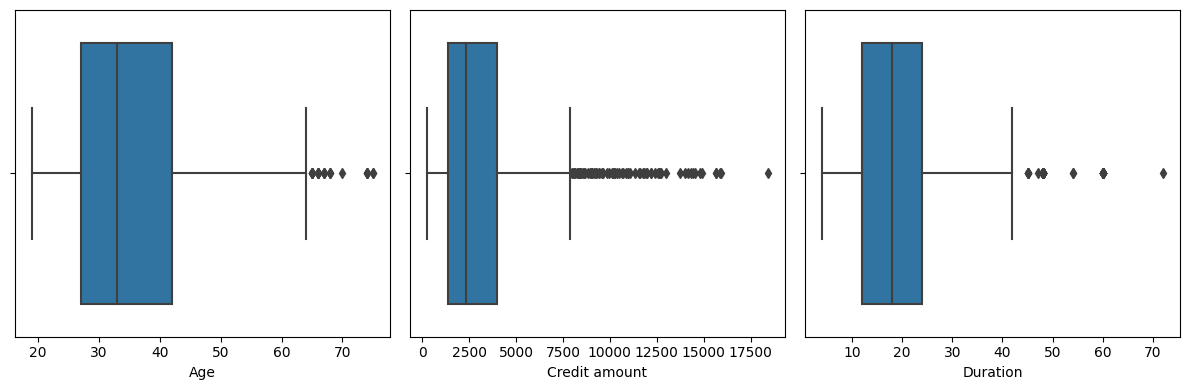

In [ ]:
num_vars = df.select_dtypes(exclude='object').drop('Job', axis=1).columns
multiple_plots(df, num_vars, sns.boxplot)
plt.tight_layout()
plt.show()

Распределение возраста и суммы кредита приблизительно нормальные со скосом вправо, а срок кредита отдаленно напоминает его.

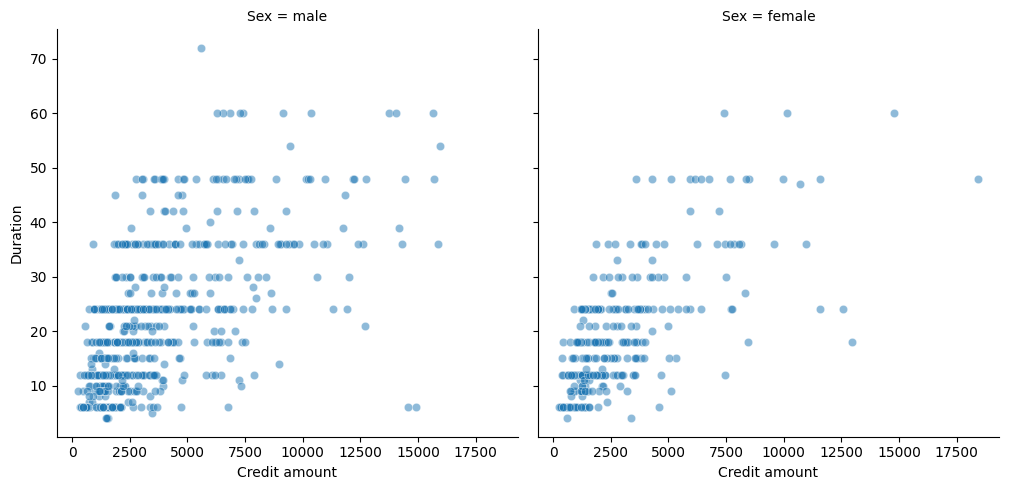

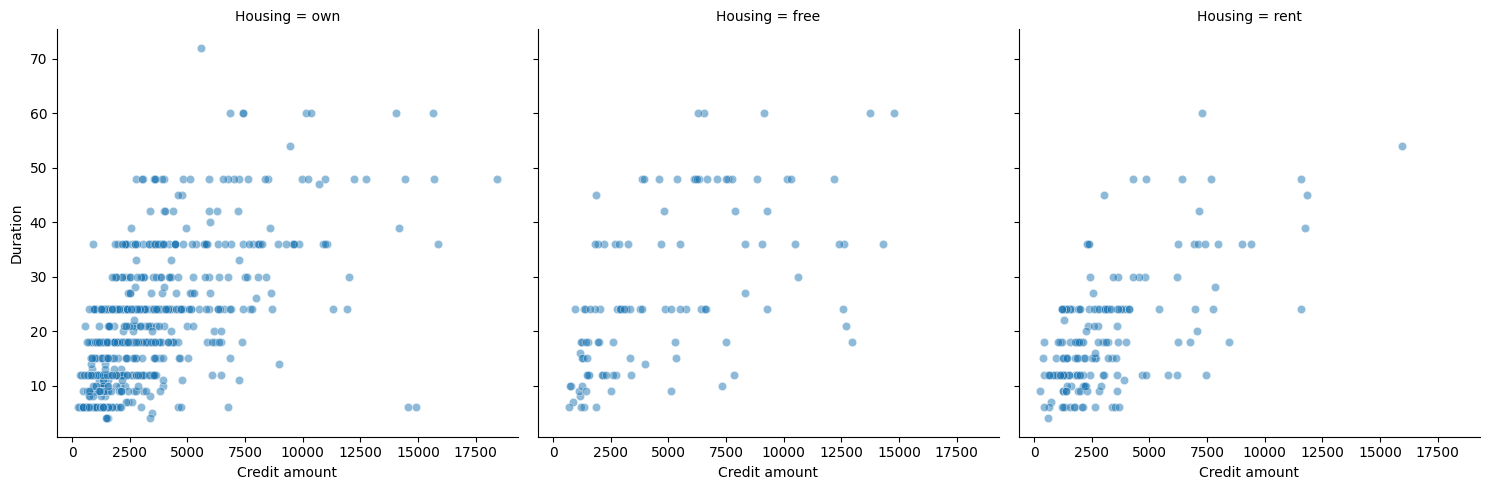

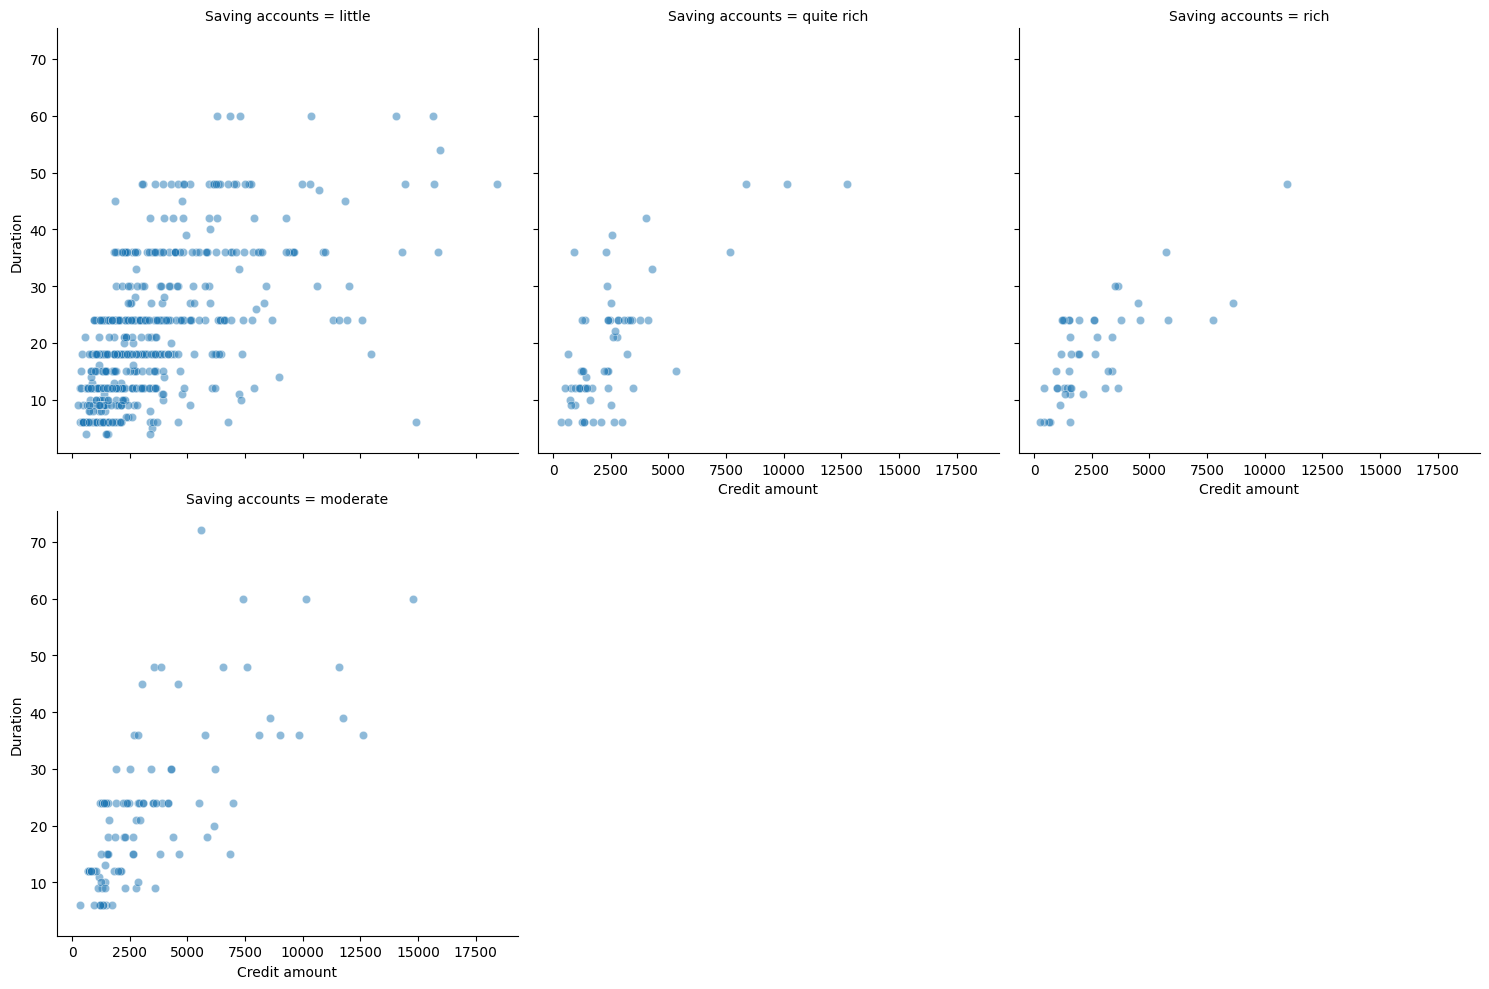

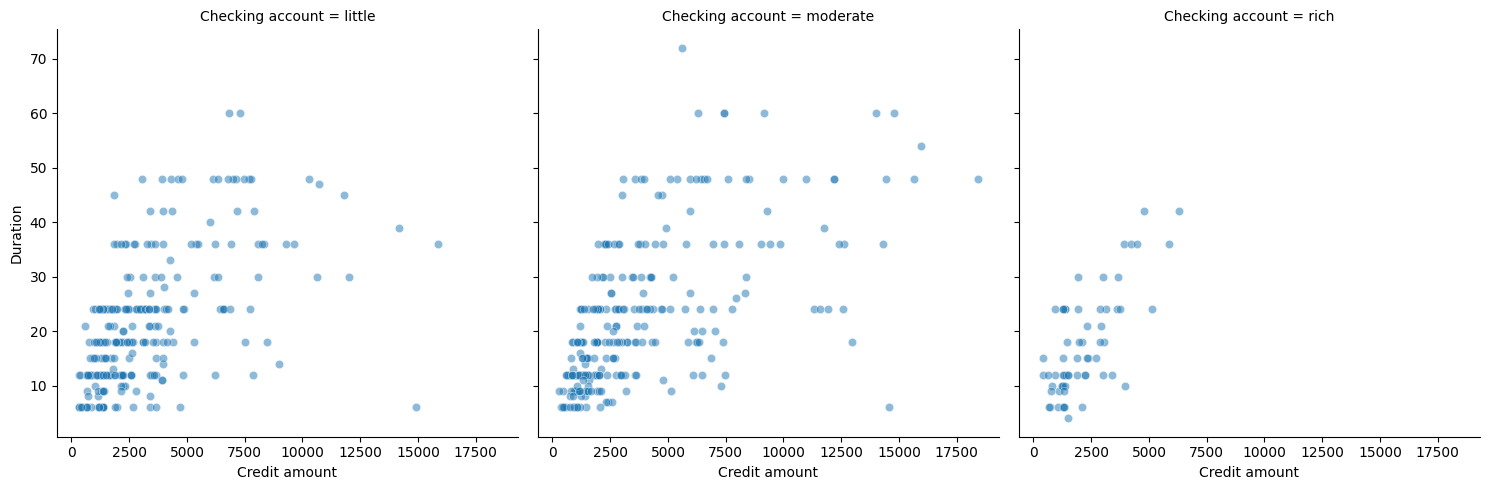

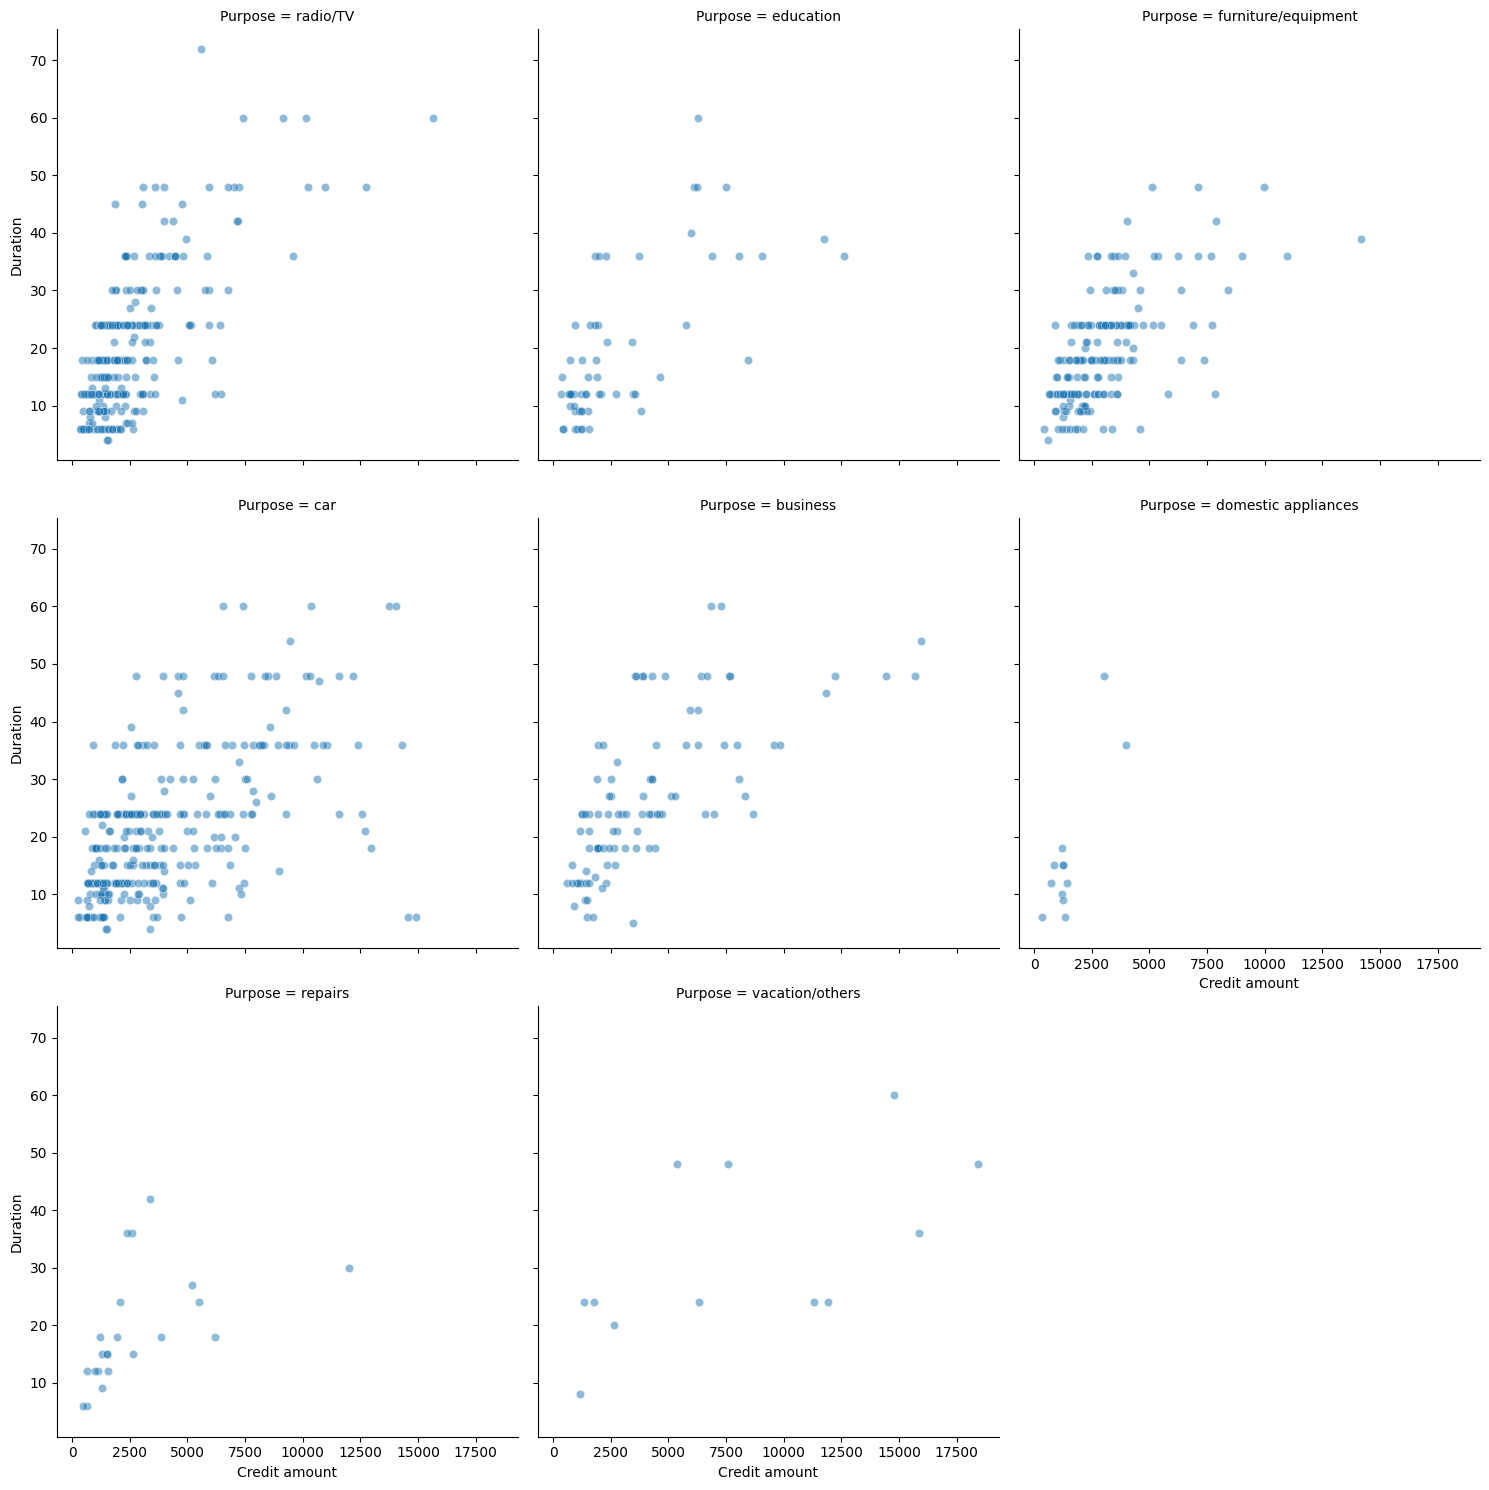

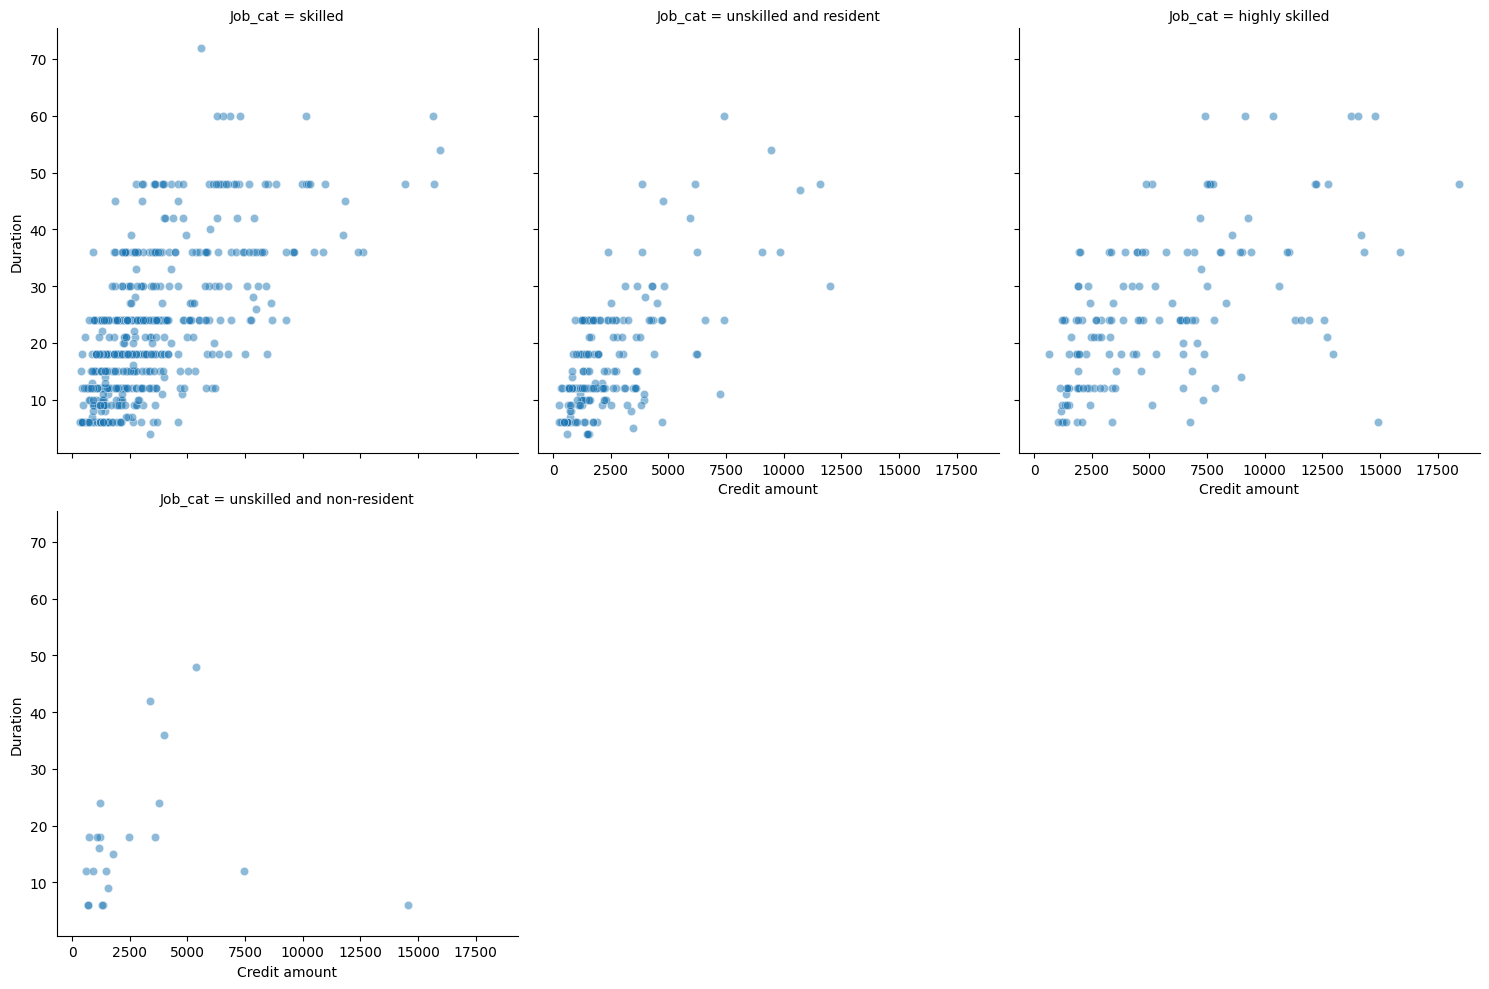

In [ ]:
for cat in cat_vars:
    sns.relplot(data=df, x='Credit amount', y='Duration', col=cat, col_wrap=3, alpha = 0.5)
    plt.show()

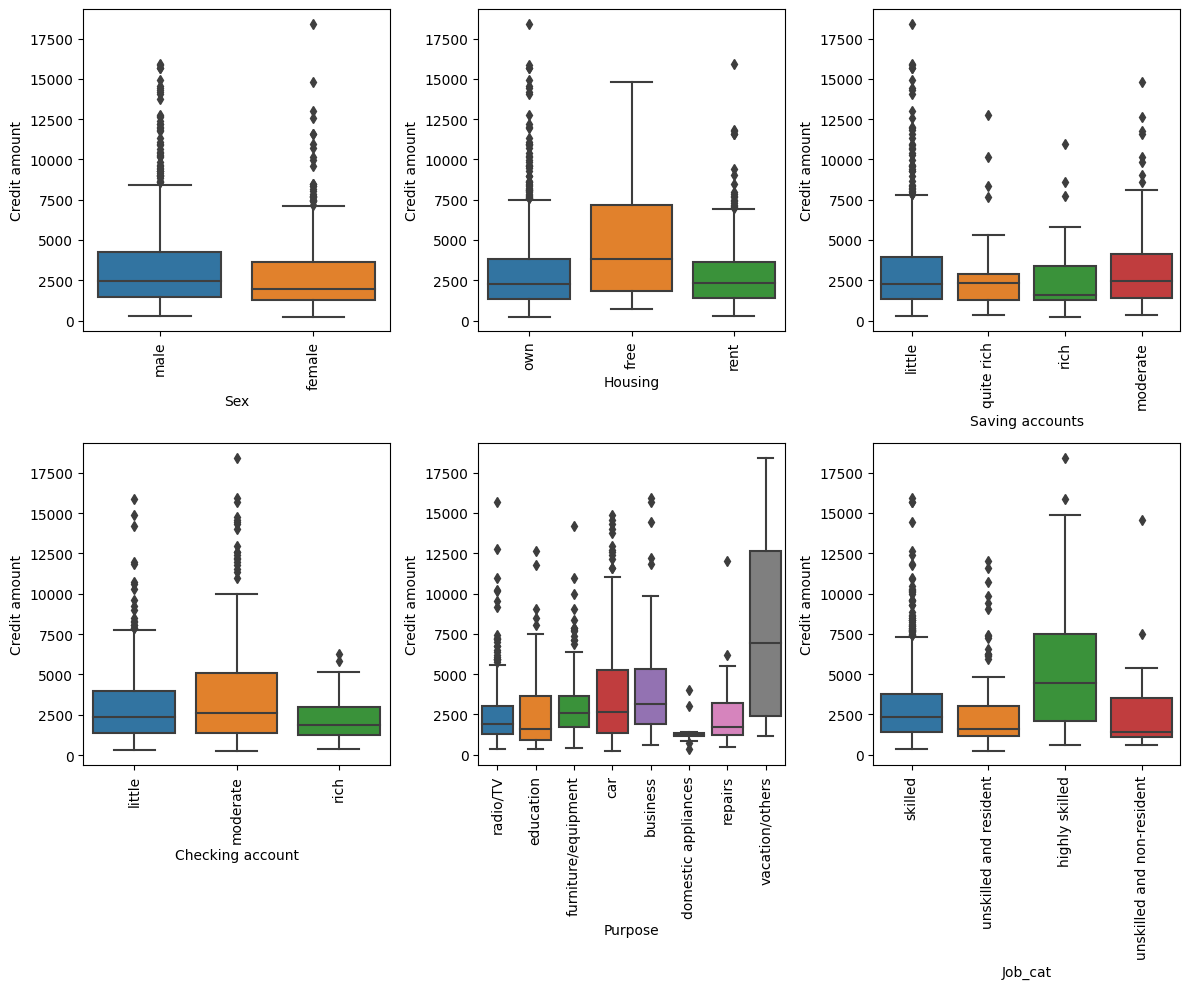

In [ ]:
accounts = ['Saving accounts', 'Checking account', 'Job_cat']
multiple_plots(df, cat_vars, sns.boxplot, y='Credit amount', xyrot=(90,0), gheight=5)
plt.tight_layout()
plt.show()

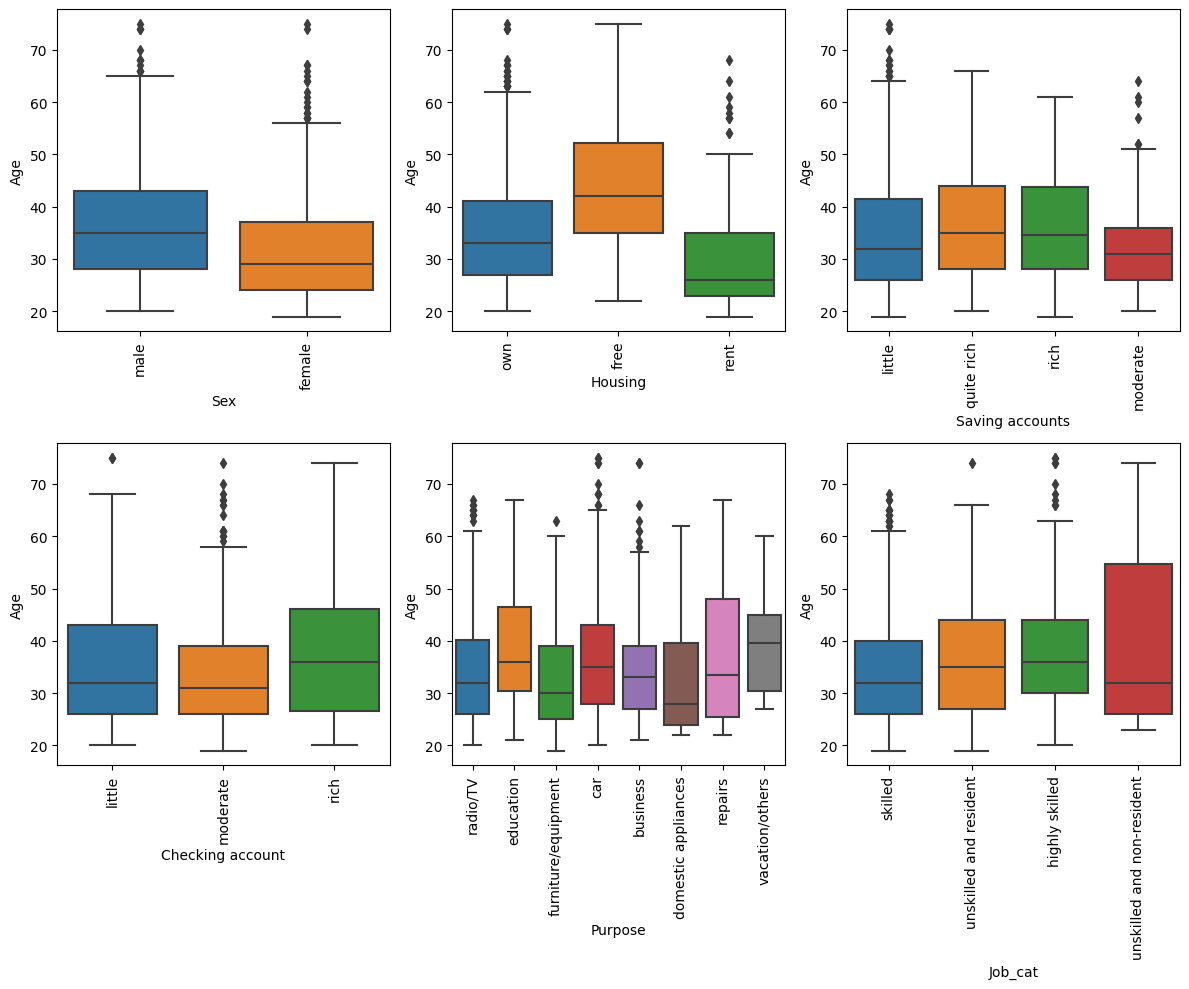

In [ ]:
multiple_plots(df, cat_vars, sns.boxplot, y='Age', xyrot=(90,0), gheight=5)
plt.tight_layout()
plt.show()

## Data Pre-processing
Нужно закодировать категориальные данные:
- Sex
- Housing
- Saving accounts
- Checking account  
- Purpose

Все будем кодировать с помощью OrdinalEncoder, использование dummy variables излишне увеличит размерность простанства.

Age и Credit amount прологарифмируем, чтобы привести распределение к нормальному.

In [ ]:
df = df.fillna('unknown')
# categories to encode
enc_vars = list(cat_vars)
enc_vars.remove('Job_cat')
# categories order
sex_ord = ['male', 'female']
housing_ord = ['free', 'rent', 'own']
savacc_ord = ['little', 'moderate', 'quite rich', 'rich', 'unknown']
checkacc_ord = ['little', 'moderate', 'rich', 'unknown']
purp_ord = df.groupby('Purpose')['Credit amount'].mean().sort_values().index
enc_cat = [sex_ord, housing_ord, savacc_ord, checkacc_ord, purp_ord]
# encoder for categorical data
ordenc = OrdinalEncoder(categories=enc_cat)
# copy features
X = df.drop(['Job_cat'], axis=1).copy(deep=True)
X['Credit amount'] = np.log(X['Credit amount'])
X['Duration'] = np.log(X['Duration'])
# encode
X[enc_vars] = ordenc.fit_transform(X[enc_vars])
X

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,0.0,2,2.0,4.0,0.0,7.063904,1.791759,1.0
1,22,1.0,2,2.0,0.0,1.0,8.691315,3.871201,1.0
2,49,0.0,1,2.0,0.0,3.0,7.647786,2.484907,3.0
3,45,0.0,2,0.0,0.0,0.0,8.972337,3.737670,4.0
4,53,0.0,2,0.0,0.0,0.0,8.490849,3.178054,5.0
...,...,...,...,...,...,...,...,...,...
995,31,1.0,1,2.0,0.0,3.0,7.459339,2.484907,4.0
996,40,0.0,3,2.0,0.0,0.0,8.257645,3.401197,5.0
997,38,0.0,2,2.0,0.0,3.0,6.689599,2.484907,1.0
998,23,0.0,2,0.0,0.0,0.0,7.520235,3.806662,1.0


Последний шаг - приведение данных к одному масштабу с помощью стандартизации, чтобы все признаки имели одинаковое влияние на кластеризацию.

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 2.76645648, -0.67028006,  0.14694918, ..., -0.933901  ,
        -1.86486906, -1.37453169],
       [-1.19140394,  1.49191369,  0.14694918, ...,  1.16304581,
         1.7083687 , -1.37453169],
       [ 1.18331231, -0.67028006, -1.38377145, ..., -0.1815588 ,
        -0.67378981, -0.3073487 ],
       ...,
       [ 0.21583532, -0.67028006,  0.14694918, ..., -1.4161991 ,
        -0.67378981, -1.37453169],
       [-1.10345149, -0.67028006,  0.14694918, ..., -0.34591111,
         1.59746802, -1.37453169],
       [-0.75164167, -0.67028006,  0.14694918, ...,  0.82450846,
         1.59746802,  0.75983429]])

## Dimension Reduction
Применим алгоритмы уменьшения размерности для визуализации данных на двумерной плоскости

In [ ]:
def scatter_noticks (x, y, ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.tick_params(labelbottom=False, labelleft=False)
    sns.set_style('white')
    sns.scatterplot(x=x, y=y, ax=ax, hue=labels)
    
def visualise_dimred(dimred, dimred_labs, data_labs=None, ncol=3, **kwargs):
    nplot = len(dimred)
    nrow = ceil(nplot/ncol)
    fig, axes = plt.subplots(1, ncol)
    fig.set_size_inches(5*ncol, 4)
    for i, dr in enumerate(dimred):
        scatter_noticks(dr[:,0], dr[:,1], axes[i], data_labs, **kwargs)
        axes[i].set_title(dimred_labs[i])
    return fig, axes

### PCA

<ipython-input-44-b49fbbee383b>:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'1_x', '0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, pca_df, right_index=True, left_index=True)


Explained Variance Ratio
PC1: 0.22019700352056376
PC2: 0.1460487576967353


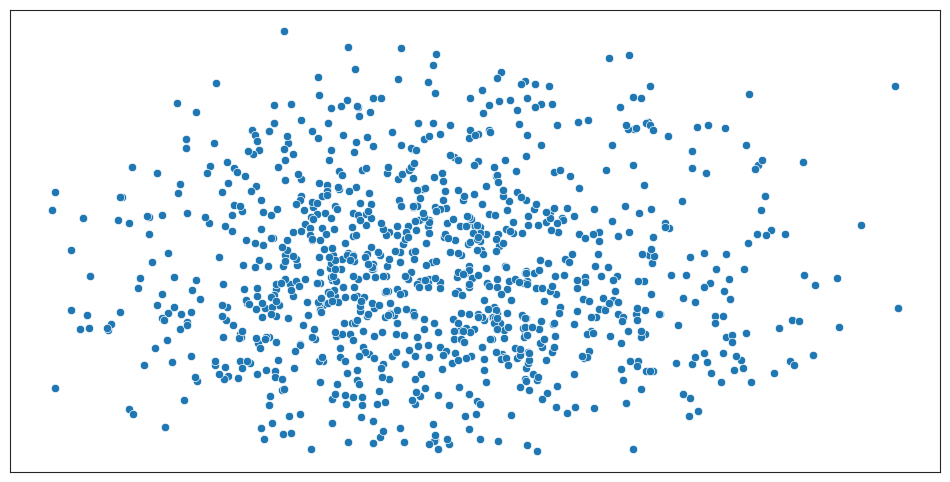

In [ ]:
pca = PCA(n_components=2, random_state=2020)
X_pca = pca.fit_transform(X)

#Merge with df
pca_df = pd.DataFrame(X_pca)
df = pd.merge(df, pca_df, right_index=True, left_index=True)

print('Explained Variance Ratio')
for i in range(2):
    print('PC{}: {}'.format(i+1,pca.explained_variance_ratio_[i]))

scatter_noticks(X_pca[:,0], X_pca[:,1])
plt.show()

Text(0, 0.5, 'Explained variance')

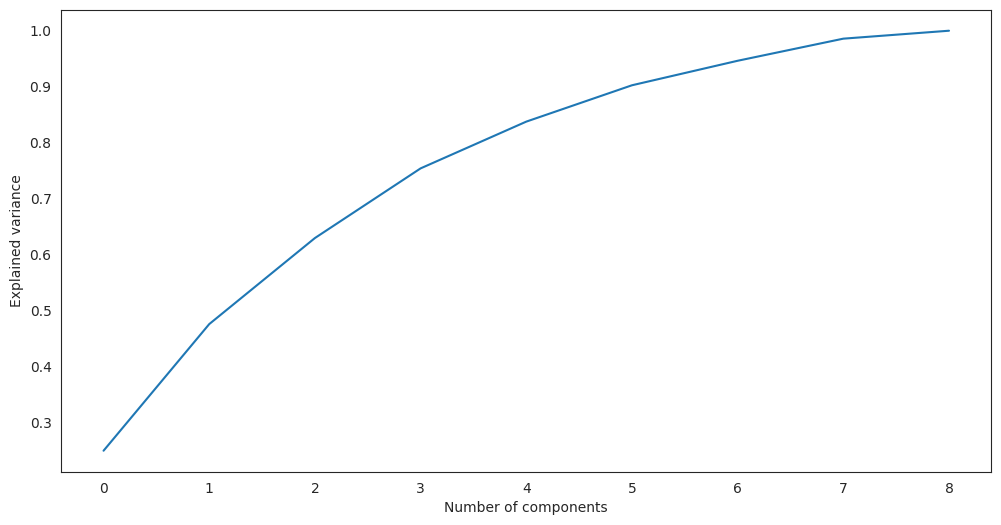

In [72]:
pca = PCA(n_components = 0.3)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

pca = PCA().fit(data_rescaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

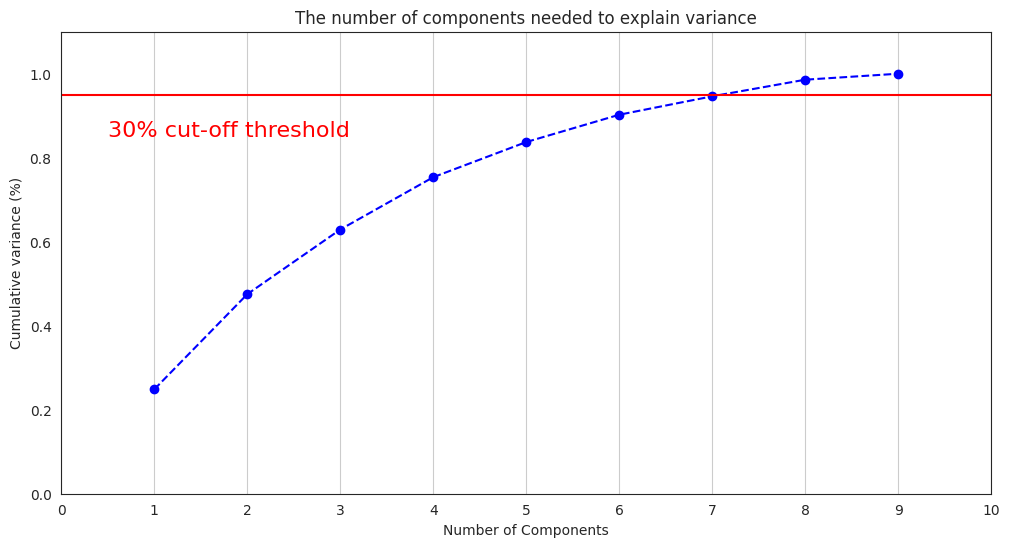

In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(data_rescaled)

#95% of variance
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.3)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

pca = PCA().fit(data_rescaled)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 10, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '30% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In this case, to get 30% of variance explained I need 7 principal components

### t-SNE

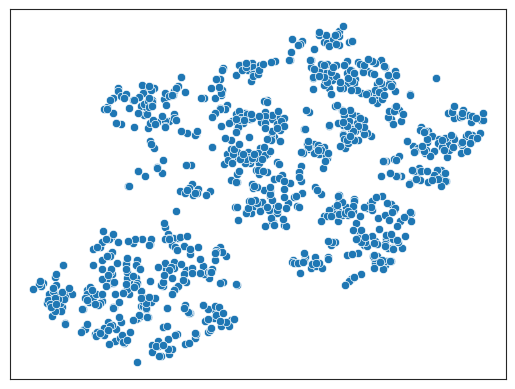

In [ ]:
tsne = TSNE(n_components=2, random_state=77)
X_tsne = tsne.fit_transform(X)

scatter_noticks(x=X_tsne[:, 0], y=X_tsne[:, 1])
plt.show()

UMAP

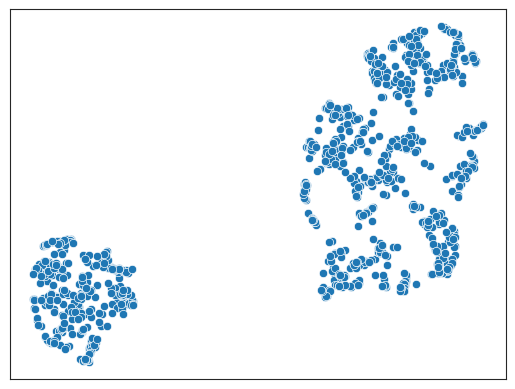

In [ ]:
reducer = umap.UMAP(random_state=77)
X_umap = reducer.fit_transform(X)

scatter_noticks(x=X_umap[:, 0], y=X_umap[:, 1])
plt.show()

По визулизациям на плоскости (t-SNE и UMAP) похоже, что выделяются два кластера.

## Clusterisation

In [ ]:
viz_dr = partial(visualise_dimred, 
                 dimred=[X_pca, X_tsne, X_umap], 
                 dimred_labs=['PCA', 't-SNE', 'UMAP'])

### K-Means
Сперва нужно выбрать количество кластеров. Для этого применим метод логтя и силуэтный коэффициент.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

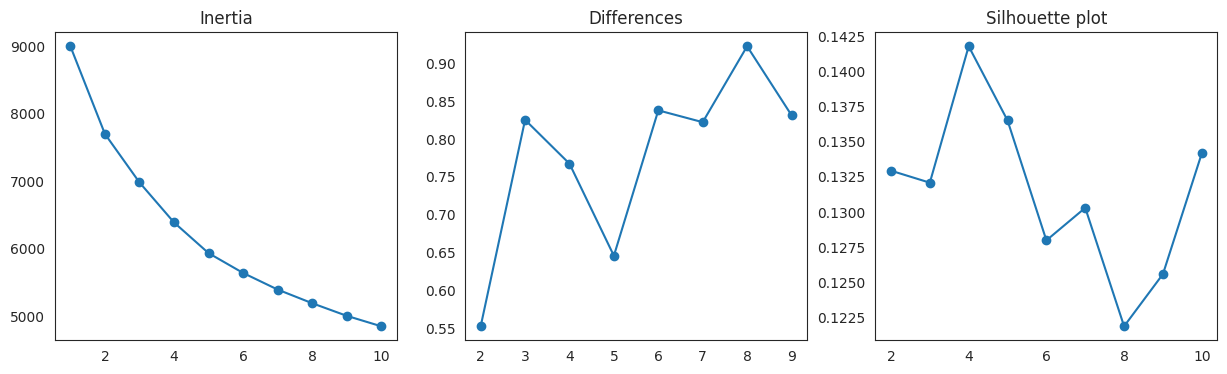

In [ ]:
# calculate inertia and silhouette score
from sklearn.metrics import silhouette_score
inertia = []
silhouette = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=77)
    kmeans.fit(X)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)
    if i != 1:
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        silhouette.append(score)
# calculate differences
D = []
for i in range(1,9):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)
# Visualising
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 4)
# inertia plot
ax[0].set_title('Inertia')
ax[0].plot(range(1,11), inertia, marker='o')
# D
ax[1].set_title('Differences')
ax[1].plot(range(2,10), D, marker='o')
# silhouette score
ax[2].set_title('Silhouette plot')
ax[2].plot(range(2,11), silhouette, marker='o')
plt.show()

По методу логтя выходит, что лучшее число кластеров - это 2, по силуэтному 
коэффициенту - 4.  
Обучим 2 модели на 2 и 4 кластерах и визуализируем результаты кластеризаций:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


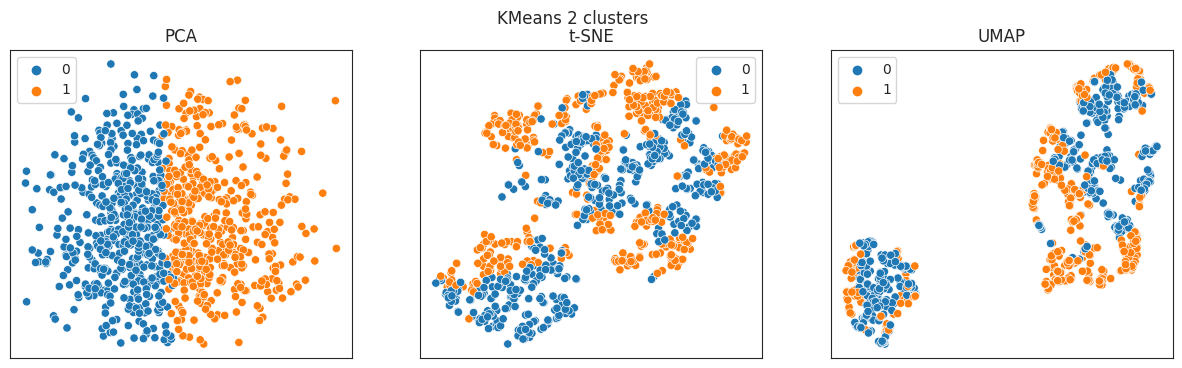

In [ ]:
# Training model
kmeans2 = KMeans(n_clusters=2, random_state=77).fit(X)
# Getting results
labels = kmeans2.labels_
# Visualising
fig, axes = viz_dr(dimred=[X_pca, X_tsne, X_umap], data_labs=labels.astype('str'))
fig.suptitle('KMeans 2 clusters')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


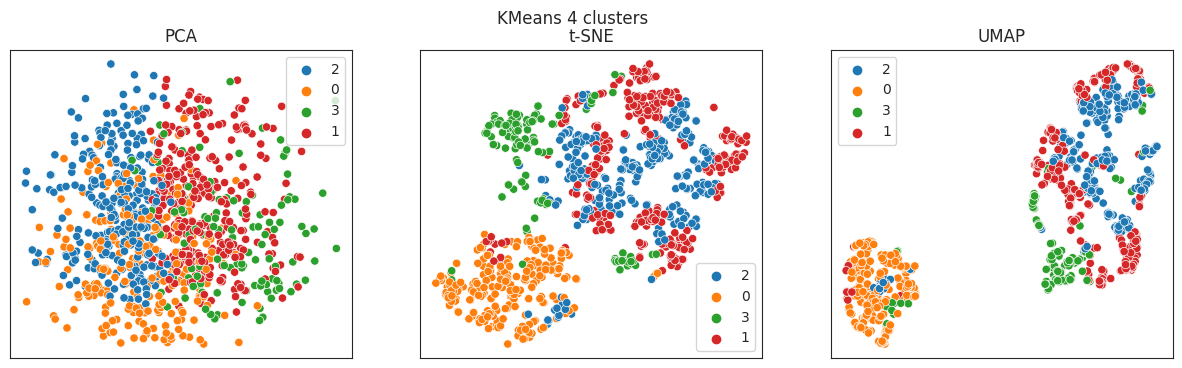

In [ ]:
# Training model
kmeans4 = KMeans(n_clusters=4, random_state=77).fit(X)
# Getting results
labels = kmeans4.labels_
# Visualising
fig, axes = viz_dr(dimred=[X_pca, X_tsne, X_umap], data_labs=labels.astype('str'))
fig.suptitle('KMeans 4 clusters')
plt.show()

DBSCAN
Для работы алгоритма нам нужно подобрать значения гиперпараметров. Будем подбирать размер окружности  ϵ
  с помощью силуэтного коэффициента и стабильности в количестве находимых кластеров.

In [ ]:
def plot_sil_nclust (eps, sil, nclust):
    fig, ax = plt.subplots()
    color = 'tab:red'
    color = 'tab:red'
    ax.plot(eps, sil, marker='o', color=color)
    ax.set_xlabel('eps')
    ax.set_ylabel('silhouette', color=color)
    ax.tick_params(axis='y', labelcolor=color)

    ax_tw = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax_tw.plot(eps, nclust, marker='o', color=color)
    ax_tw.set_ylabel('n_clusters', color=color)  
    ax_tw.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    return fig

100%|██████████| 17/17 [00:02<00:00,  7.70it/s]


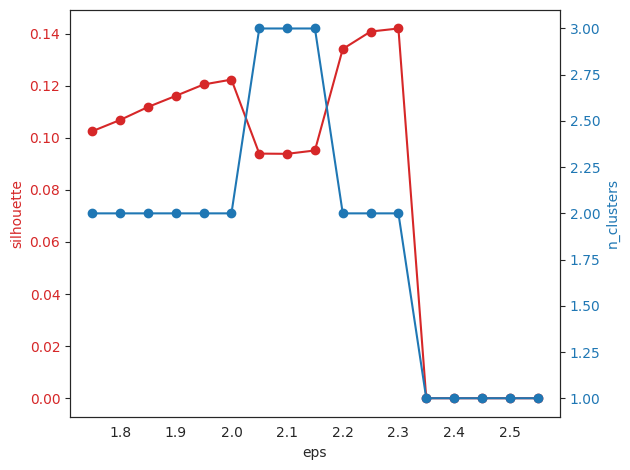

In [ ]:
# calculate silhouette score and number of clusters
silhouette = []
clusters = []
eps_range = np.arange(1.75,2.6,0.05)
for i in tqdm(eps_range):
    dbscan = DBSCAN(eps=i).fit(X)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(X, labels)
    else:
        score = 0
    silhouette.append(score)
    clusters.append(n_clusters)
plot_sil_nclust(eps_range, silhouette, clusters)
plt.show()

Силуэтный коэффициент максимален для  ϵ > 2,2, но мы возьмем  ϵ
 =2,1, чтобы было три, а не два кластера.

Обучим модель и визуализируем результат.

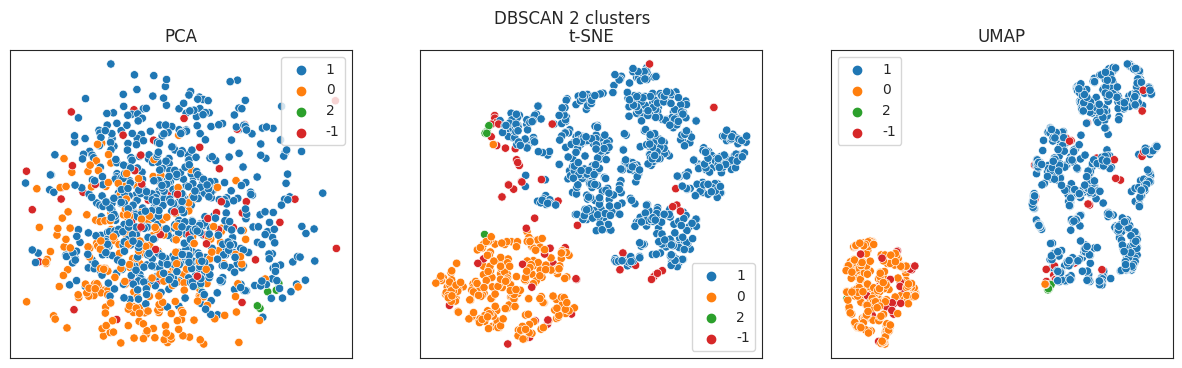

In [ ]:
# Training model
dbscan = DBSCAN(eps=2.1).fit(X)
# Getting results
labels = dbscan.labels_
# Visualising
fig, axes = viz_dr(dimred=[X_pca, X_tsne, X_umap], data_labs=labels.astype('str'))
fig.suptitle('DBSCAN 2 clusters')
plt.show()

## Interpretation

In [ ]:
# report function
def report(df, model):
    df['cluster'] = model.labels_
    df['cluster'] = df.cluster.astype('str')
    # size of clusters
    cluster_count = df.groupby('cluster').size().reset_index().set_axis(['cluster','n'], axis=1)
    print('Size of clusters')
    display(cluster_count)
    # numerical
    print('Mean')
    display(df.groupby('cluster').mean())
    print('Median')
    display(df.groupby('cluster').median())
    fig, axes = multiple_plots(df, num_vars, sns.boxplot, y='cluster', orient='h')
    fig.suptitle('Numeric variables distribution')
    plt.show()
    g = sns.relplot(data=df, x='Credit amount', y='Duration', col='cluster', 
                    col_wrap=3, alpha = 0.5, hue='Housing', style='Sex', size='Age')
    g.fig.suptitle('Duration vs. Credit amount per cluster')
    plt.tight_layout()
    plt.show()
    # categorical
    fig,axes = plt.subplots(2, 3)
    fig.suptitle('Categorical variables')
    fig.set_size_inches(15, 10)
    for (cat, ax) in zip(cat_vars, axes.flatten()):
        pct_count = df.groupby(['cluster', cat]).size().reset_index()
        pct_count = pct_count.merge(cluster_count, how='inner', on='cluster')
        pct_count['percentage'] = pct_count[0]/pct_count['n']
        sns.barplot(data=pct_count, x=cat, y='percentage', hue='cluster', ax=ax)
        ax.tick_params('x', labelrotation=90)
        ax.set_ylabel('Percentage of cluster')
        plt.tight_layout()
    plt.show()
    #ncol = 3
    #nrow = ceil(len(cat_vars)/ncol)
    #fig, axes = plt.subplots(nrow, ncol)
    #fig.set_size_inches(ncol*4, nrow*4.5)
    #fig.suptitle('Categorical variables')
    #for ax, cat in zip(axes.flatten(), cat_vars):
    #    sns.countplot(data=df, x=cat, ax=ax, hue='cluster', order=df[cat].value_counts().index)
    #    ax.tick_params('x', labelrotation=90)
    #plt.tight_layout()
    #plt.show()

### KMeans
#### 2 clusters

Size of clusters


,cluster,n
0,0,527
1,1,473


Mean


<ipython-input-25-bf13c2fd25d3>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(df.groupby('cluster').mean())


,Age,Job,Credit amount,Duration
cluster,,,,
0,35.261860,1.633776,1678.880455,13.521822
1,35.862579,2.205074,5045.429175,29.126850


Median


<ipython-input-25-bf13c2fd25d3>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(df.groupby('cluster').median())


,Age,Job,Credit amount,Duration
cluster,,,,
0,33.0,2.0,1414.0,12.0
1,33.0,2.0,4020.0,24.0


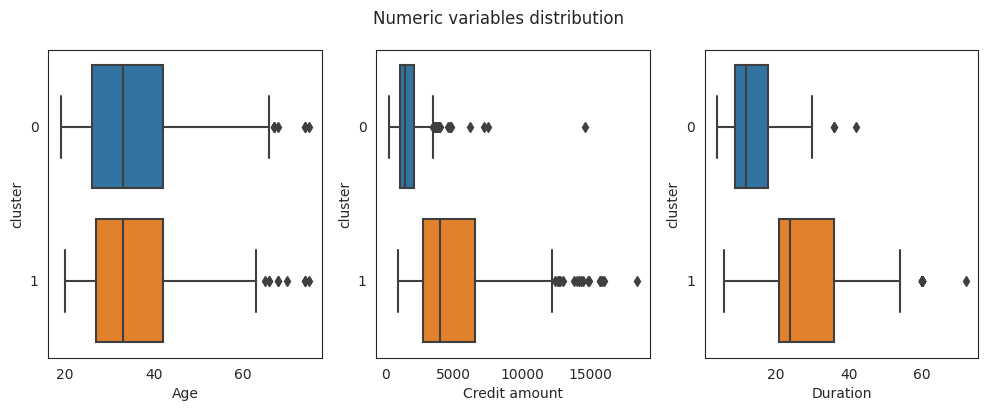

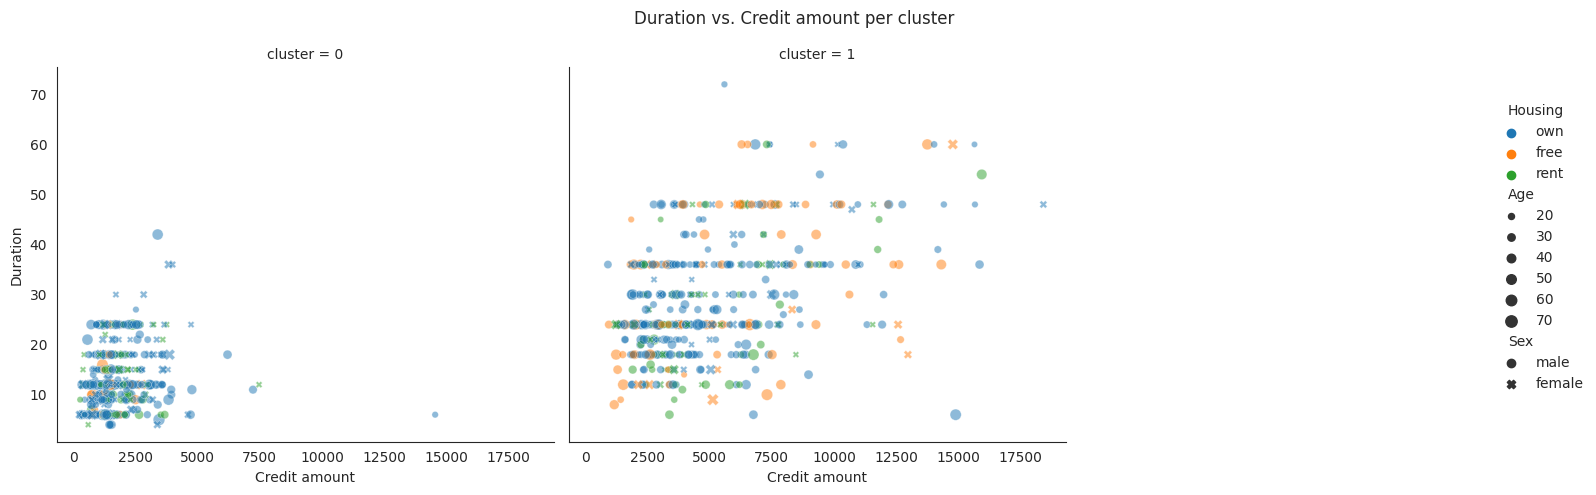

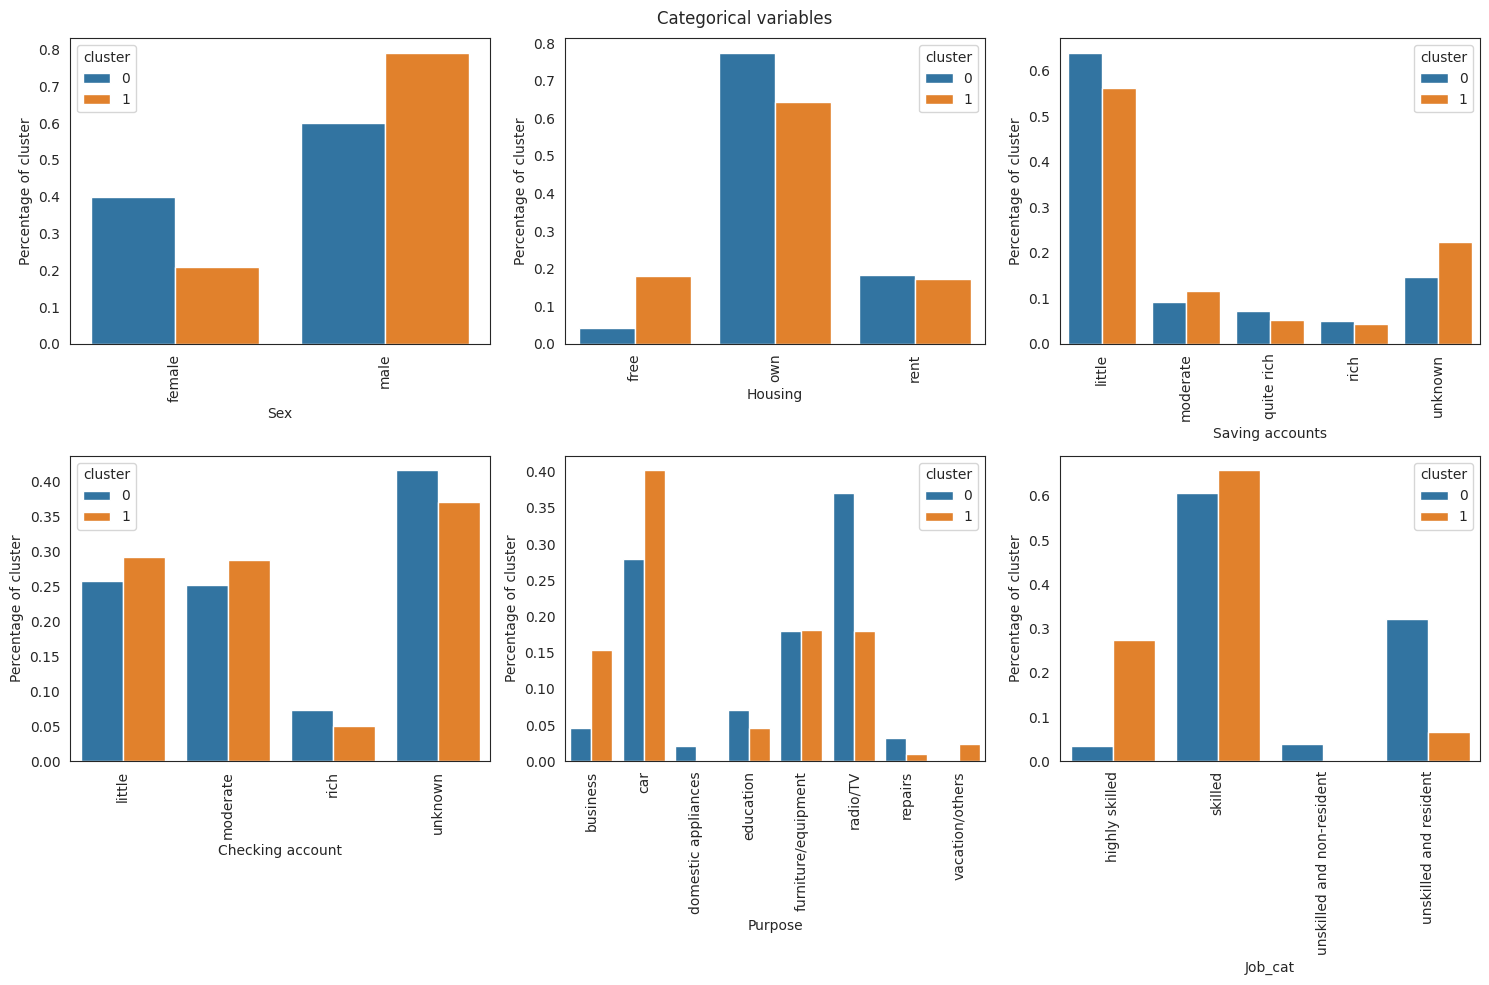

In [ ]:
report(df, kmeans2)

Кластеры:

0 -  Клиенты с небольшими кредитами (средняя сумма - 1679) и короткими сроками (средний срок - 14 месяцев). Больший процент клиентов с работой не требующей специальных навыков (unskilled), чем в другом кластере.  
1 - Клиенты с более крупными кредитами (средняя сумма - 5045) и более длинными сроками (средний срок - 29 месяцев).

#### 4 clusters

Size of clusters


,cluster,n
0,0,258
1,1,318
2,2,301
3,3,123


Mean


<ipython-input-25-bf13c2fd25d3>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(df.groupby('cluster').mean())


,Age,Job,Credit amount,Duration
cluster,,,,
0,29.914729,1.794574,2444.934109,18.189922
1,34.323899,2.182390,4815.257862,28.647799
2,37.936877,1.594684,1613.149502,12.149502
3,44.666667,2.170732,5070.365854,27.991870


Median


<ipython-input-25-bf13c2fd25d3>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(df.groupby('cluster').median())


,Age,Job,Credit amount,Duration
cluster,,,,
0,27.0,2.0,1881.5,18.0
1,32.0,2.0,3841.0,24.0
2,36.0,2.0,1372.0,12.0
3,44.0,2.0,3905.0,24.0


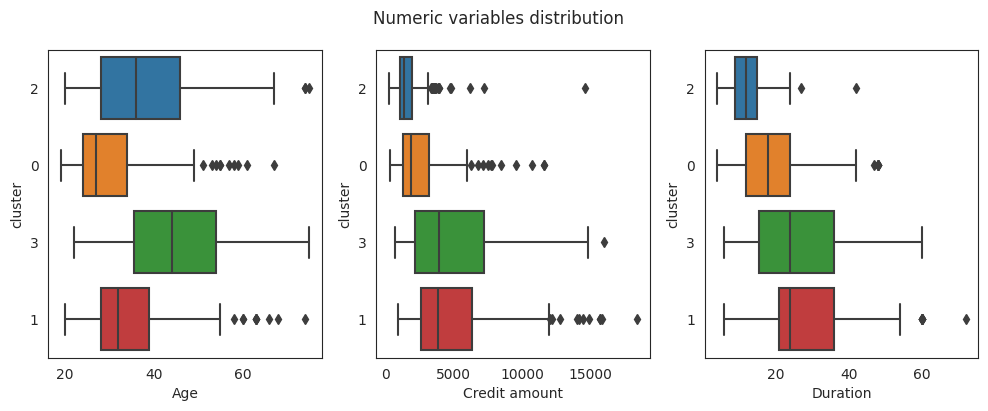

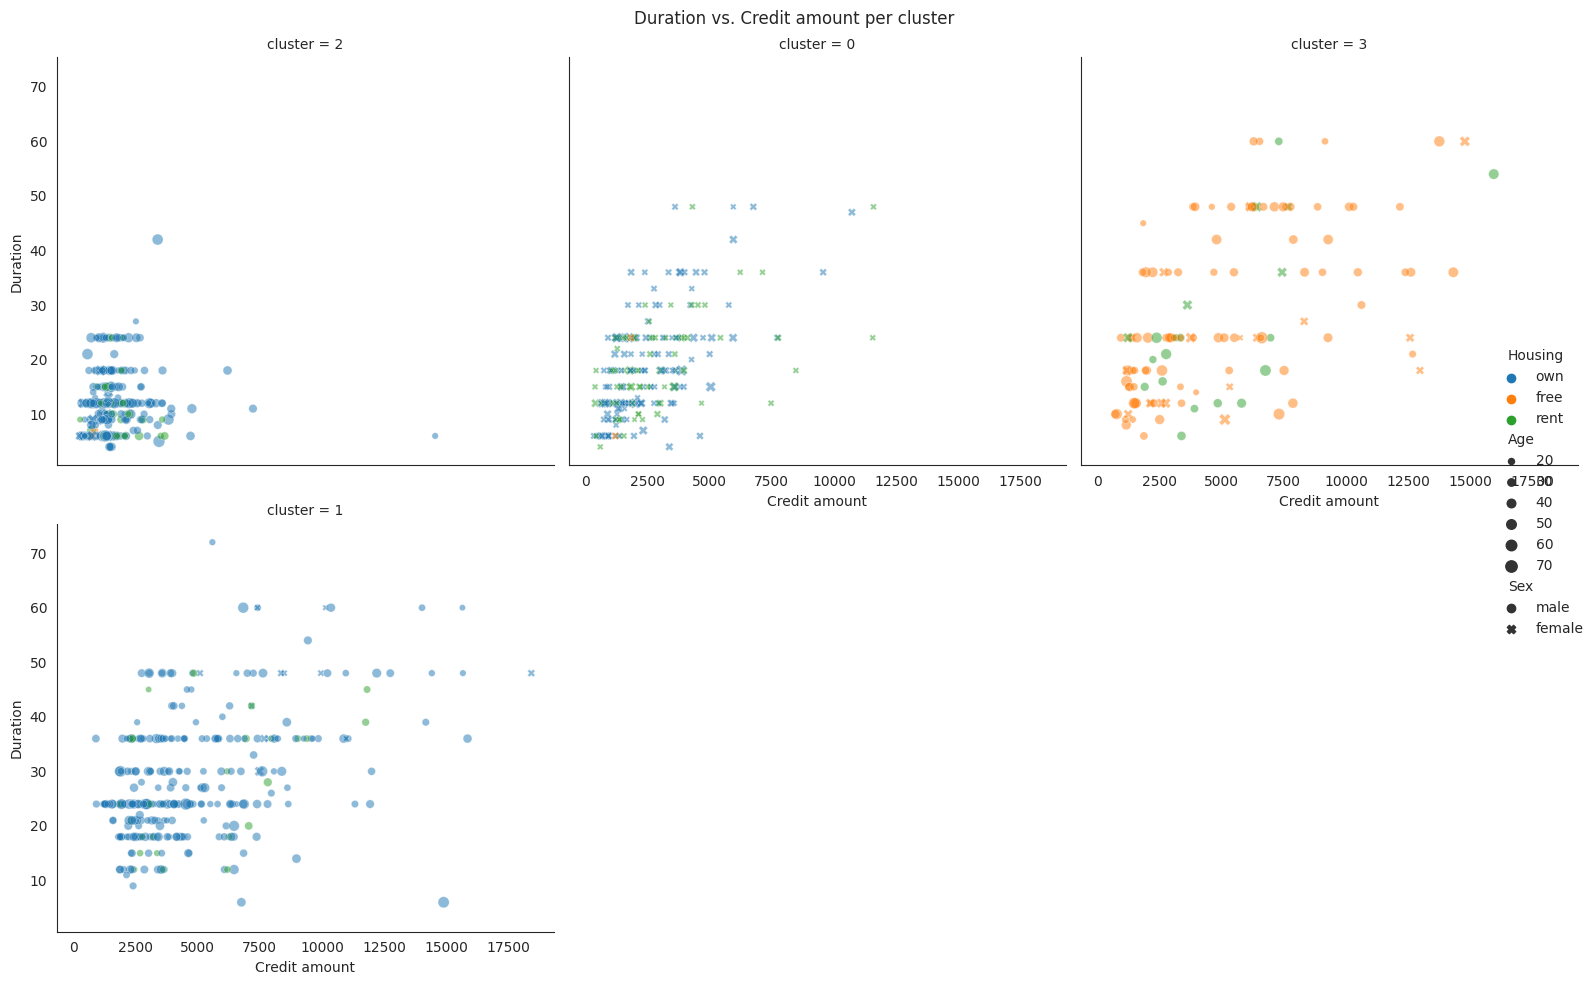

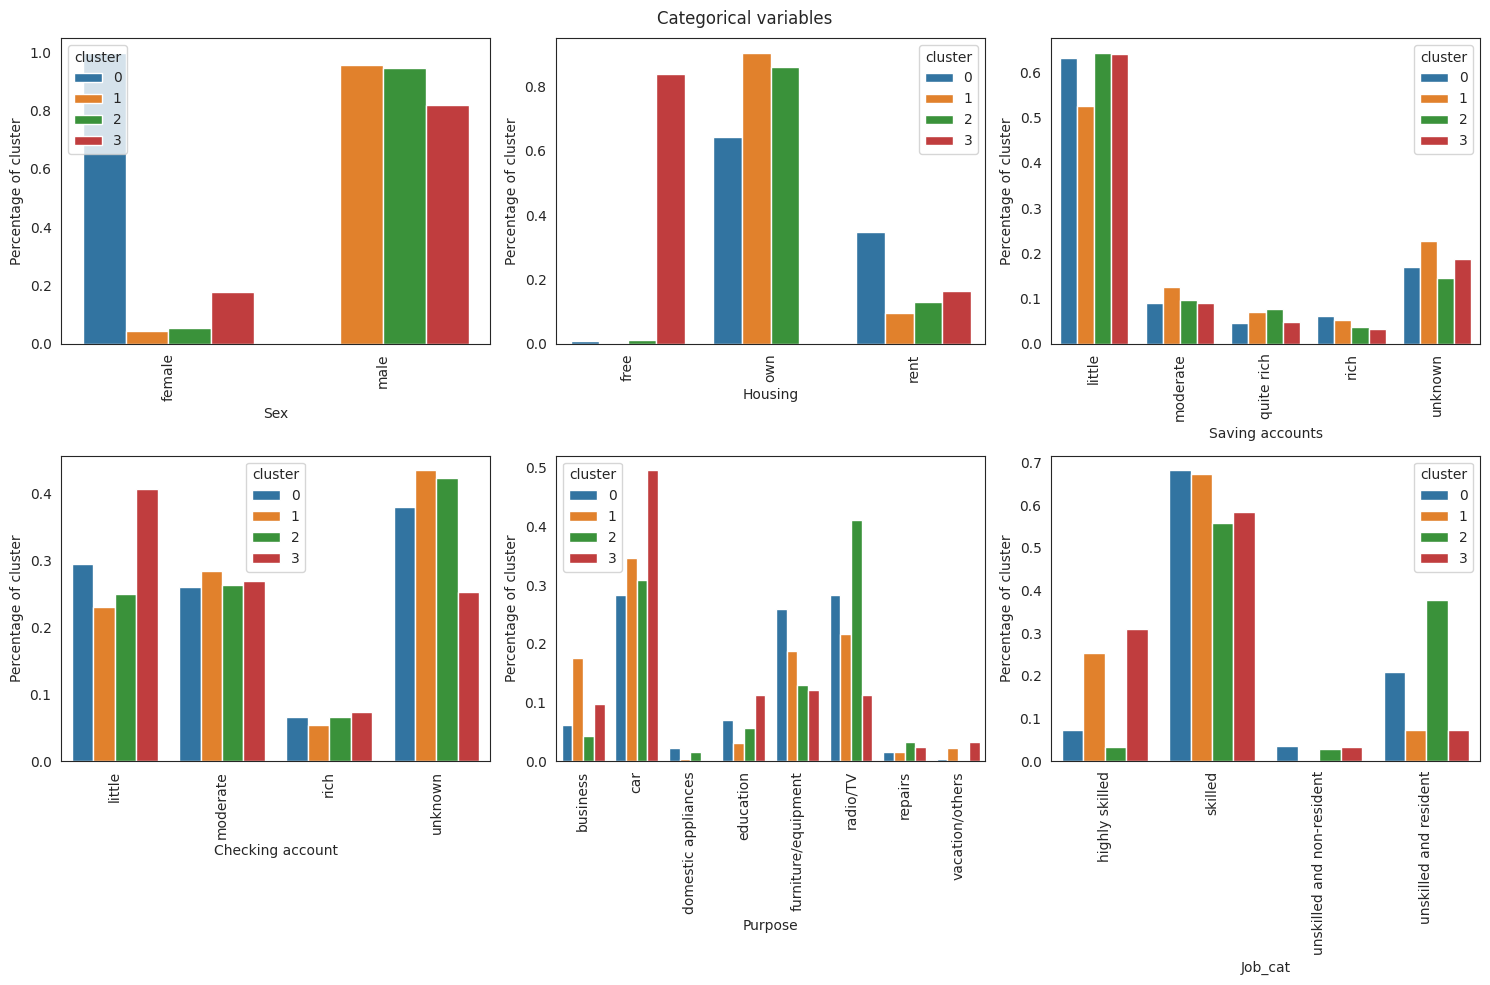

In [ ]:
report(df, kmeans4)

Кластеры:

0 - Искллючительно женщины, преимущественно молодые (средний возраст 30 лет, медиана - 27). В среднем берут крудиты на сумму 2445 и на срок 18 месяцев.  
1 - Преимущественно молодые люди (средний возраст 34 года, медиана - 32), в большей степени мужчины. В среднем берут более крупные кредиты на сумму 4815 и на более длинные сроки (29 месяцев). По сравнению с с другими кластерами, люди из этого кластера чаще имеют работу, требующую навыков (в т.ч. высоких).  
2 - Люди без собственного жилья (в большей степени мужчины), берут небольшие кредиты (средняя сумма - 1613) на короткие сроки (средний срок - 12 месяцев).  
3 - Люди преимущественно среднего (средний возраст и медиана 45 и 44) возраста (в большей степени мужчины). В среднем берут большие кредиты (средняя сумма - 5070) сроком 28 месяцев. По сравнению с с другими кластерами (0 и 2), чаще имеют работу требующую навыков (в т.ч. высоких).

## Conclusion

Самое простое и легко интерпретируемое разделение показал алгоритм KMeans c двумя кластерами: маленькие недолгие по срокам кредиты и большие и долгие по срокам кредиты. С 4мя кластерами разделение тоже довольно понятное: 
- молодые женщины, берут кредиты поменьше и покороче;
- молодые люди с более квалифицированной работой, берущие более крупные кредиты;
- люди без свего жилья, с небольшими короткими кредитами;
- люди среднего возраста, берут более крупные кредиты.  

Стоит отметить, что все алгоритмы смогли выделить кластер из преимущественно молодых женщин, который, судя по визуализациям, стабилен между разными алгоритмами. 

DBSCAN выделил два крупных кластера: один только с женщинами, другой только с мужчинами. Он так же нашел интересый, но очень малочисленный (6), кластер с женщинами с хорошей работой, которые берут в целом крупные на средние сроки. В выбросы, который больше чем один из кластеров, попали преимущественно люди более зрелого возраста.